# Document Reader - Experimento

Preencha aqui com detalhes sobre a tarefa.<br>
### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [2]:
dataset = "/tmp/data/new_dense_retrirver_result.csv" #@param {type:"string"}
question = "Qual é o melhor herbicida para erva da ninha ?" #@param {type:"string",label:"Pergunta para a qual os contextos devem ser ranqueados"}
top = 10 #@param {type:"integer",label:"Número de passagens em que o Reader tem maior certeza de ser a reposta correta retornar"}
column_retriever_score = "retriever_score" #@param {type:"string",label:"Coluna Retriever Score",description:"Nome da coluna que conterá o score dos contextos ranqueados após a inferência do modelo. Apenas considerado se retriever_reader_pipeline=True"}
column_reader_score = "reader_score" #@param {type:"string",label:"Coluna Reader Score",description:"Nome da coluna que conterá o score das respostas encontradas após a inferência do modelo"}
retriever_reader_pipeline = True #@param {type:"boolean",label:"Retriever Reader Pipeline",description:"Se True o componente considera a pipeline de Retriever-Reader. Caso contrário considera apenas o Reader isolado"}
reader_score_weight = 0.8 #@param {type:"float",label:"Proporção da resposta do reader",description:"Proporção do reader na resposta final. A proporção do retriever será a complementação para chegar a 1.0. Apenas considerado se retriever_reader_pipeline=True"}
remove_no_answer_found = True #@param {type:"boolean",label:"Desconsidera respostas nulas",description:"Desconsidera as respostas nulas retornadas pelo reader"}
ntops_overall = 5 #@param {type:"integer",label:"Melhores resultados segundo o Overall Score"}

# Dataset
column_context = "context" #@param {type:"string",label:"Coluna contexto",description:"Coluna em que estão contidas os contextos"}
column_doc_id = "doc_id" #@param {type:"string",label:"Coluna com o ID do contexto",description:"Nome da coluna que contexto os ids dos contextos a serem ranqueados"}
column_question = "question" #@param {type:"string",label:"Coluna pergunta",description:"Coluna em que estão contidas as perguntas. Apenas considerada se train_from_zero=True"}
column_answer_start = "answer_start" #@param {type:"string",label:"Coluna posição inicio da resposta",description:"Coluna com a posição de início da resposta na string. Apenas considerada se train_from_zero=True"}
column_answer_end= "answer_end" #@param {type:"string",label:"Coluna posição fim da resposta",description:"Coluna com a posição de fim da resposta na string. Apenas considerada se train_from_zero=True"}
train_from_zero = False #@param {type:"boolean",label:"Treinamento do algorítimo do zero",description:"Caso True utiliza o algorítimo com finne-tunning no squad em português. Caso True retreina do zero"}
train_from_squad = False #@param {type:"boolean",label:"Treinamento do algorítimo pelo Sqaud",description:"Caso True utiliza treinará algorítimo com finne-tunning no squad em português. Caso False teinará com o dataset passado"}

#prepare_data
dev_size_from_data= 0.2 #@param {type:"float",label:"Porcentagem para avaliação",description:"Parcela dos dados utilizadas para avaliação, sendo o restante utilizado para treino. Apenas considerada se train_from_zero=True e train_from_squad=True"}
test_size_from_dev= 0.5 #@param {type:"float",label:"Porcentagem para teste",description:"Parcela dos dados utilizadas para avaliação que serã utilizados para teste, sendo o restante utilizado para validação. Apenas considerada se train_from_zero=True"}
batch_dataset_preparation = 30 #@param {type:"float",label:"Batch para preparação dos dados",description:"Tamanho do batchque o tokenizador utilizará para preparar o dataset. Apenas considerada se train_from_zero=True"}

#hyperparams
model_name= "neuralmind/bert-large-portuguese-cased" #@param {type:"string",label:"Modelo",description:"Modelo utilizado da base de modelo do hugginfaces"}
train_batch_size= 2 #@param {type:"integer",label:"Batch size para treino"}
eval_batch_size= 2 #@param {type:"integer",label:"Batch size para inferência"}
max_length= 384 #@param {type:"integer",label:"Tamanho da sentença",description:"Tamanho máximo da sentença Contexto + Question em tokens"}
doc_stride= 128 #@param {type:"integer",label:"Passo do documento", description:"Quando uma sequência é dividia em N, o argumento doc_stride delimita o quanto a sentença seguinte possuirá de tokens da sentença anterior"}
learning_rate= 3.0e-5 #@param {type:"float",label:"Taxa de aprendizado"}
eps= 1.0e-08 #@param {type:"integer",float:"Valor de estabilidade do otimizador Adam"}
seed = 13 #@param {type:"integer",label:"Semente de aleatoriedade"}

#lightning_params
num_gpus= 1 #@param {type:"integer",label:"Numero de GPUs"}
profiler= True #@param {type:"integer",label:"Resumo"}
max_epochs= 2 #@param {type:"integer",label:"Máximo de épocas para treinamento"}
accumulate_grad_batches= 16 #@param {type:"integer",label:"Batchs acumulados",description:"Batchs acumulados antes de atualizar os pesos"}
check_val_every_n_epoch= 1 #@param {type:"integer",label:"Frequência Validação",description:"Frequência da chamada da validação em épocas"}
progress_bar_refresh_rate= 1 #@param {type:"integer",label:"Frequência de autuazaliação da barra de progresso"}
gradient_clip_val= 1.0 #@param {type:"float",label:"Favor de corte dos gradientes","description":"O fator evita que os gradientes explodam definindo um limite para os mesmos"}
fast_dev_run= False #@param {type:"boolean",label:"Rodar um batch",description:"Utilizado para validar que todas as partes estão funcionando antes de treinar o modelo por inteiro"}

#early_stop_callback
monitor= 'avg_train_loss' #@param {type:"integer",label:"Frequência de autuazaliação da barra de progresso"}
min_delta= 0.01 #@param {type:"integer",label:"Variação mínima entre épocas"}
patience= 1 #@param {type:"integer",label:"Epera após atingir variação mínima"}
verbose= False #@param {type:"boolean",label:"Disponibilizar informações early stop"}
mode= 'min' #@param ["min","max"] {type:"integer",label:"Modo de parada",description: "Modo de funcionamento para critério de parada"}

In [3]:
if retriever_reader_pipeline and (reader_score_weight<0 or reader_score_weight>1):
    raise ValueError("reader_score_weight deve ser entre 0 e 1")

## Leitura do conjunto de dados

O exemplo abaixo faz a leitura de dados tabulares (ex: .csv).<br>
Modifique o código de acordo com o tipo de dado que desejar ler.

In [4]:
import pandas as pd

df = pd.read_csv(dataset)
columns = df.columns

## Divide dataset em subconjuntos de treino, validação e teste

Subconjunto de treino: amostra de dados usada para treinar o modelo.<br>
Subconjunto de treino: amostra de dados usada para validar o modelo.<br>
Subconjunto de teste: amostra de dados usada para fornecer uma avaliação imparcial do treinamento do modelo no subconjunto de dados de treino.

In [6]:
from sklearn.model_selection import train_test_split
    
if (train_from_zero and not train_from_squad):
    df_train,df_ = train_test_split(df, train_size=dev_size_from_data)
    df_valid, df_test = train_test_split(df_, train_size=test_size_from_dev)
    train_output = 'df_squad_train_bert_chuncked.csv'
    valid_output = 'df_squad_valid_bert_chuncked.csv'
    test_output =  'df_squad_test_bert_chuncked.csv'
    df_train.to_csv(os.path.join(train_output),index=False)
    df_valid.to_csv(os.path.join(valid_output),index=False)
    df_test.to_csv(os.path.join(test_output),index=False)
else:
    df_test = df

## Configurando Argumentos

In [7]:
# Mapeando dirpaths
import os
data_dir  =  root_dir = os.getcwd()
logs_dir = os.path.join(root_dir,"lightning_logs")
# Colocando parâmetros de entrada no fromato esperado
hparams = {
    "model_name":model_name,
    "train_batch_size":train_batch_size,
    "eval_batch_size":eval_batch_size,
    "max_length":max_length,
    "doc_stride":doc_stride,
    "learning_rate":learning_rate,
    "eps":eps,
    "seed":seed,
    
}

lightning_params = {
    "num_gpus":num_gpus,
    "profiler":profiler,
    "max_epochs":max_epochs,
    "accumulate_grad_batches":accumulate_grad_batches,
    "check_val_every_n_epoch":check_val_every_n_epoch,
    "progress_bar_refresh_rate":progress_bar_refresh_rate,
    "gradient_clip_val":gradient_clip_val,
    "fast_dev_run":fast_dev_run,
}


early_stop_callback_params = {
     "monitor":monitor,
    "min_delta":min_delta,
    "patience":patience,
    "verbose":verbose,
    "mode":mode,    
}

prepare_data_params = {
     "batch_dataset_preparation":batch_dataset_preparation,
     "test_size_from_dev":test_size_from_dev,
}

# Configurações
config = {'params':{'hparams':hparams,
                    'lightning_params':lightning_params,
                    'early_stop_callback_params':early_stop_callback_params,
                    'prepare_data_params':prepare_data_params },

        'dirpaths':{'data_dirpath':data_dir,
                'log_dirpath':logs_dir,
                'cwd_dirpath':root_dir},
}

## Treinamento do Zero / Recuperação dos pesos

In [8]:
import os
import pytorch_lightning as pl
from caller import Reader_Caller

# Criando Caller
reader_caller = Reader_Caller(config)

#Fazendo Build
reader_caller.build()

if train_from_zero:
        
    #Preparando dados
    if train_from_squad:
        squad_train_path = os.path.join(data_dir,'squad-train-v1.1.json')
        squad_dev_path= os.path.join(data_dir,'squad-dev-v1.1.json')
        
        prepared_datapaths = reader_caller.prepare_data(squad_train_path=squad_train_path,
                                                        squad_dev_path=squad_dev_path)
    else:
        
        prepared_datapaths = {
                                'prepared_data_train_path':train_output,
                                 'prepared_data_valid_path':valid_output,
                                 'prepared_data_test_path':test_output
                             }
    
    
    # Treinamento
    _ = reader_caller.train(train_path=prepared_datapaths['prepared_data_train_path'],
                            valid_path=prepared_datapaths['prepared_data_valid_path'],
                            test_path=prepared_datapaths['prepared_data_test_path'])
    
    MODEL_PATH = "trained_model.ckpt"
    reader_caller.save_checkpoint(MODEL_PATH)
    
    # Avaliação
    reader_caller.evaluate()
else:
    MODEL_PATH = "default_document_reader_squad_pt.ckpt"
    if not os.path.exists(MODEL_PATH):
        !wget -nc https://storage.googleapis.com/platiagro/Vident/default_document_reader_squad_pt.ckpt
    
    reader_caller.load_model(checkpoint_path=MODEL_PATH)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Global seed set to 13


Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint a

## Ranqueando contextos para a pergunta

In [11]:
from aux_functions import build_result_dataframe
contexts_dict = {row[column_doc_id]:row[column_context] for i,row in df_test.iterrows()}
df_result = reader_caller.forward(question=question,topn_contexts=list(contexts_dict.values()),top_ids=list(contexts_dict.keys()))
df_result = build_result_dataframe(df_input = df_test,
                                   df_result = df_result,
                                   ntops_overall = ntops_overall,
                                   reader_score_weight = reader_score_weight,
                                   retriever_reader_pipeline = retriever_reader_pipeline,
                                   remove_no_answer_found = remove_no_answer_found,
                                   column_doc_id = column_doc_id,
                                   column_retriever_score = column_retriever_score,
                                   column_reader_score = column_reader_score)

## Visualizando os resultados

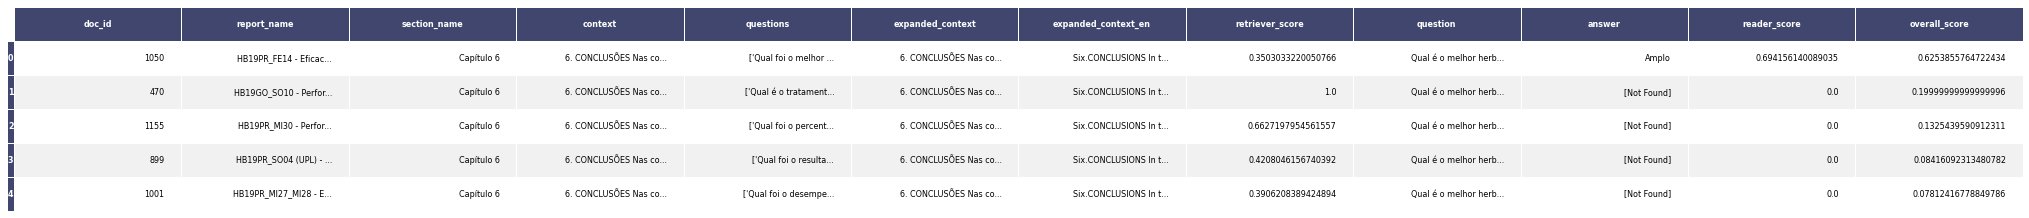

In [12]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table
ax = plot_data_table(df_result)
plt.show()

In [10]:
df_result.to_csv(dataset, index=False)

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [10]:
from joblib import dump

artifacts = {
    "model":reader_caller,
    "columns":columns,
    "question":question,
    "ntops_overall":ntops_overall,
    "reader_score_weight":reader_score_weight,
    "retriever_reader_pipeline":retriever_reader_pipeline,
    "remove_no_answer_found":remove_no_answer_found,
    "column_doc_id":column_doc_id,
    "column_context":column_context,
    "column_retriever_score":column_retriever_score,
    "column_reader_score":column_reader_score
}

dump(artifacts, "/tmp/data/document_reader.joblib")

['/tmp/data/document_reader.joblib']

## Liberando Memória da GPU

In [11]:
import torch
reader_caller.free_memory()
del reader_caller
torch.cuda.empty_cache() 